In [1]:
%env SDL_VIDEODRIVER=dummy

env: SDL_VIDEODRIVER=dummy


In [2]:
from pyroborobo import Pyroborobo, Controller, CircleObject, SquareObject
try:
    import numpy as np
    import moviepy
    import pandas as pd
except ImportError:
    print("Video example and data analysis will not work")
    print("run")
    print("conda install pandas")
    print("conda install -c conda-forge moviepy")
    print("for the full example")
    import_success = False
else:
    import_success = True

In [3]:
class SimpleController(Controller):

    def __init__(self, world_model):
        # It is *mandatory* to call the super constructor before any other operation to link the python object to its C++ counterpart
        Controller.__init__(self, world_model)
        assert self.nb_sensors == 8, "SimpleController only works with 8 sensors"

    def reset(self):
        pass

    def step(self):  # step is called at each time step
        self.set_translation(1)  # Let's go forward
        self.set_rotation(0)
        if (self.get_distance_at(1) < 1  # if we see something on our left
                or self.get_distance_at(2) < 1):  # or in front of us
            self.set_rotation(0.5)  # turn right
        elif self.get_distance_at(3) < 1:  # Otherwise, if we see something on our right
            self.set_rotation(-0.5)  # turn left

                
class SwitchObject(CircleObject):
    def __init__(self, id, data):
        CircleObject.__init__(self, id)  # Do not forget to call super constructor
        self.regrow_time = data['regrowTimeMax']
        self.cur_regrow = 0
        self.triggered = False
        self.gate_id = data['sendMessageTo']
        self.rob = Pyroborobo.get()  # Get pyroborobo singleton

    def reset(self):
        self.show()
        self.register()
        self.triggered = False
        self.cur_regrow = 0

    def step(self):
        if self.triggered:
            self.cur_regrow -= 1
            if self.cur_regrow <= 0:
                self.show()
                self.register()
                self.triggered = False

    def is_walked(self, rob_id):
        self.triggered = True
        self.rob.objects[self.gate_id].open()
        self.cur_regrow = self.regrow_time
        self.hide()
        self.unregister()

    def inspect(self, prefix=""):
        return "I'm a switch!"


class GateObject(SquareObject):
    def __init__(self, id, data):
        SquareObject.__init__(self, id)
        self.triggered = False
        self.regrow_time = data['regrowTimeMax']
        self.cur_regrow = 0

    def reset(self):
        self.show()
        self.register()
        self.triggered = False
        self.cur_regrow = 0

    def step(self):
        if self.triggered:
            self.cur_regrow -= 1
            if self.cur_regrow <= 0 and self.can_register():
                self.show()
                self.register()
                self.triggered = False

    def open(self):
        self.triggered = True
        self.hide()
        self.unregister()
        self.cur_regrow = self.regrow_time

    def inspect(self, prefix=""):
        return "I'm a gate!"


In [4]:
image_list = []
robot_position_list = []
rob = Pyroborobo.create("config/trap.properties",
                        controller_class=SimpleController,
                        object_class_dict={"gate": GateObject, "switch": SwitchObject},
                        override_conf_dict={"gDisplayMode": 2, "gInitialNumberOfRobots": 20})
rob.start()
for i in range(1000):
    rob.update(1)
    if import_success:
        image_list.append(np.array(rob.get_screen(), copy=True)[..., (2, 1, 0)]) # Convert from RGBA to BGR for moviepy
        for j, ctl in enumerate(rob.controllers):
            robot_position_list.append({"iter":i, "rob": j, "x": ctl.absolute_position[0], "y": ctl.absolute_position[1]})
rob.close()

In [5]:
from moviepy.editor import ImageSequenceClip
seq = ImageSequenceClip(image_list, fps=60)

In [6]:
seq.ipython_display()

t:   9%|▉         | 91/1001 [00:00<00:01, 907.88it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [7]:
robpos_df = pd.DataFrame(robot_position_list)

In [8]:
robpos_df["xbin"] = pd.cut(robpos_df["x"], 30)
robpos_df["ybin"] = pd.cut(robpos_df["y"], 30)

In [9]:
heatmap = robpos_df.pivot_table(index="ybin", columns="xbin", aggfunc="count", values="rob")

In [10]:
import matplotlib.pyplot as plt

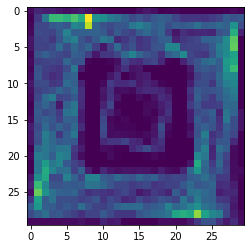

In [11]:
plt.imshow(heatmap)